In [6]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns


In [27]:
import warnings
warnings.filterwarnings('ignore')


In [1]:
from google.colab import drive
import pandas as pd
drive.mount('/content/gdrive', force_remount = True)
path = 'gdrive/My Drive/AML/loan.csv'
df = pd.read_csv(path)

Mounted at /content/gdrive


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
df.shape

(2260668, 145)

In [3]:
df.loan_status.value_counts()

Fully Paid                                             1041952
Current                                                 919695
Charged Off                                             261655
Late (31-120 days)                                       21897
In Grace Period                                           8952
Late (16-30 days)                                         3737
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     31
Name: loan_status, dtype: int64

In [4]:
df1 = df[(df['loan_status'] == 'Fully Paid')|(df['loan_status'] == 'Charged Off')]
df1.shape

(1303607, 145)

39


Text(0.5, 0, '% of Missing Value')

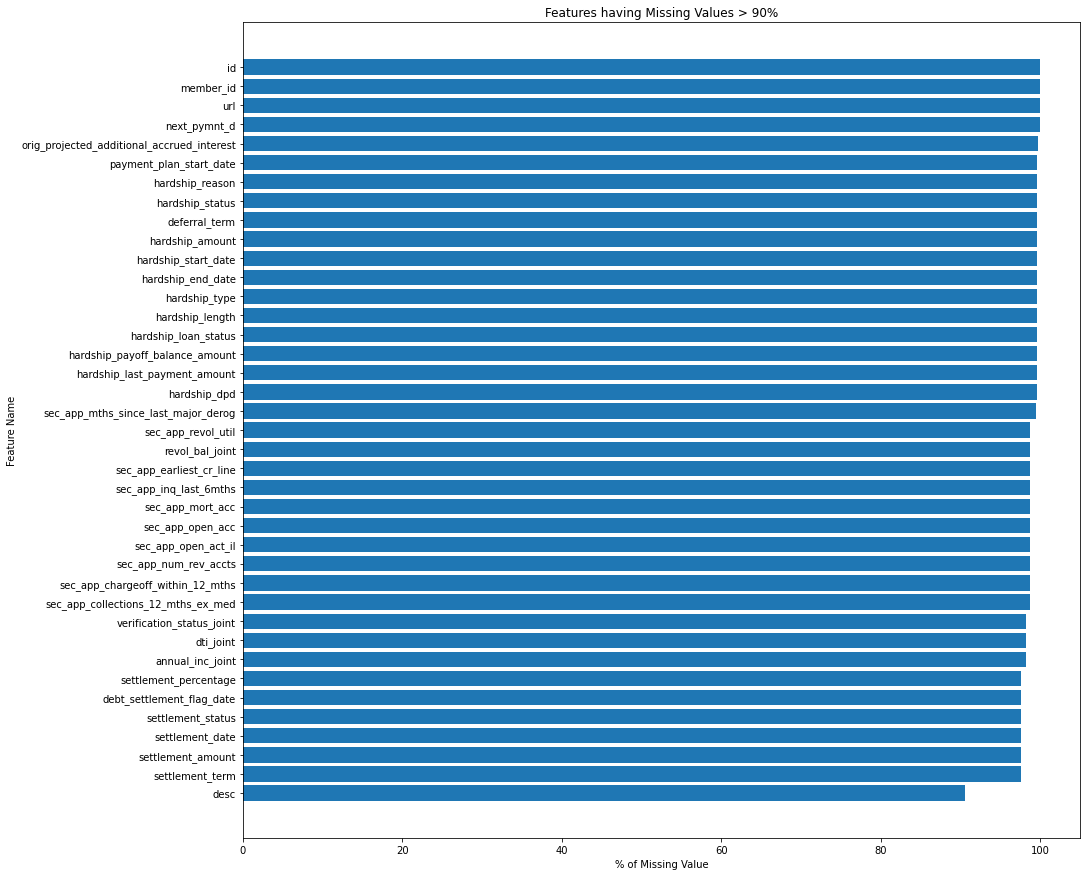

In [7]:
percentage_missing= ((df1.isna().sum()*100)/len(df1))
df1_missing_value = pd.DataFrame({'column_name': df1.columns, 'percent_missing': percentage_missing})
df1_missing_value = df1_missing_value[df1_missing_value["percent_missing"].gt(90)]
df1_missing_value = df1_missing_value.sort_values(by=['percent_missing'])
print(len(df1_missing_value))
plt.figure(figsize=(15, 15))
plt.barh(df1_missing_value.iloc[:,0], df1_missing_value.iloc[:,1])
plt.title('Features having Missing Values > 90%')
plt.ylabel('Feature Name')
plt.xlabel('% of Missing Value')

In [8]:
amount_missing = pd.DataFrame(df1.isnull().sum()/len(df1))
amount_missing.columns = ['missing_prop']
cols = amount_missing[amount_missing['missing_prop'] < 0.1].index
print(len(cols))
df2 = df1[cols].dropna(axis = 0)
df2.shape

86


(1056242, 86)

In [9]:
df2['loan_status_coded'] = df2['loan_status'].map({'Fully Paid': 1, 'Charged Off': 0})
corr = df2.corr()

In [10]:
upper_tri = corr.where(np.triu(np.ones(corr.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.80)]
print(len(to_drop))
print(to_drop)

20
['funded_amnt', 'funded_amnt_inv', 'installment', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'collection_recovery_fee', 'total_rev_hi_lim', 'avg_cur_bal', 'bc_util', 'num_actv_rev_tl', 'num_bc_sats', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'percent_bc_gt_75', 'tot_hi_cred_lim', 'total_bc_limit', 'total_il_high_credit_limit']


In [11]:
df3 = df2.drop(to_drop, axis = 1)
corr = df3.corr()
top30_correlatedNumerical = abs(corr['loan_status_coded']).sort_values(ascending = False)[:30].index
print(top30_correlatedNumerical)

Index(['loan_status_coded', 'recoveries', 'last_pymnt_amnt', 'int_rate',
       'total_rec_late_fee', 'acc_open_past_24mths', 'dti',
       'num_tl_op_past_12m', 'bc_open_to_buy', 'mort_acc', 'total_rec_int',
       'loan_amnt', 'tot_cur_bal', 'inq_last_6mths', 'mo_sin_rcnt_tl',
       'mo_sin_old_rev_tl_op', 'revol_util', 'mo_sin_rcnt_rev_tl_op',
       'mths_since_recent_bc', 'num_actv_bc_tl', 'annual_inc', 'open_acc',
       'mo_sin_old_il_acct', 'pub_rec', 'pub_rec_bankruptcies', 'revol_bal',
       'delinq_2yrs', 'num_bc_tl', 'num_accts_ever_120_pd',
       'collections_12_mths_ex_med'],
      dtype='object')


In [12]:
top30_n_high_var = df3[top30_correlatedNumerical].var().sort_values(ascending = False) > 1
top30_n_high_var = top30_n_high_var[top30_n_high_var == True].index
print(top30_n_high_var)
print(len(top30_n_high_var))

Index(['tot_cur_bal', 'annual_inc', 'revol_bal', 'bc_open_to_buy', 'loan_amnt',
       'last_pymnt_amnt', 'total_rec_int', 'recoveries',
       'mo_sin_old_rev_tl_op', 'mo_sin_old_il_acct', 'mths_since_recent_bc',
       'revol_util', 'mo_sin_rcnt_rev_tl_op', 'total_rec_late_fee', 'dti',
       'mo_sin_rcnt_tl', 'open_acc', 'int_rate', 'num_bc_tl',
       'acc_open_past_24mths', 'num_actv_bc_tl', 'mort_acc',
       'num_tl_op_past_12m', 'num_accts_ever_120_pd'],
      dtype='object')
24


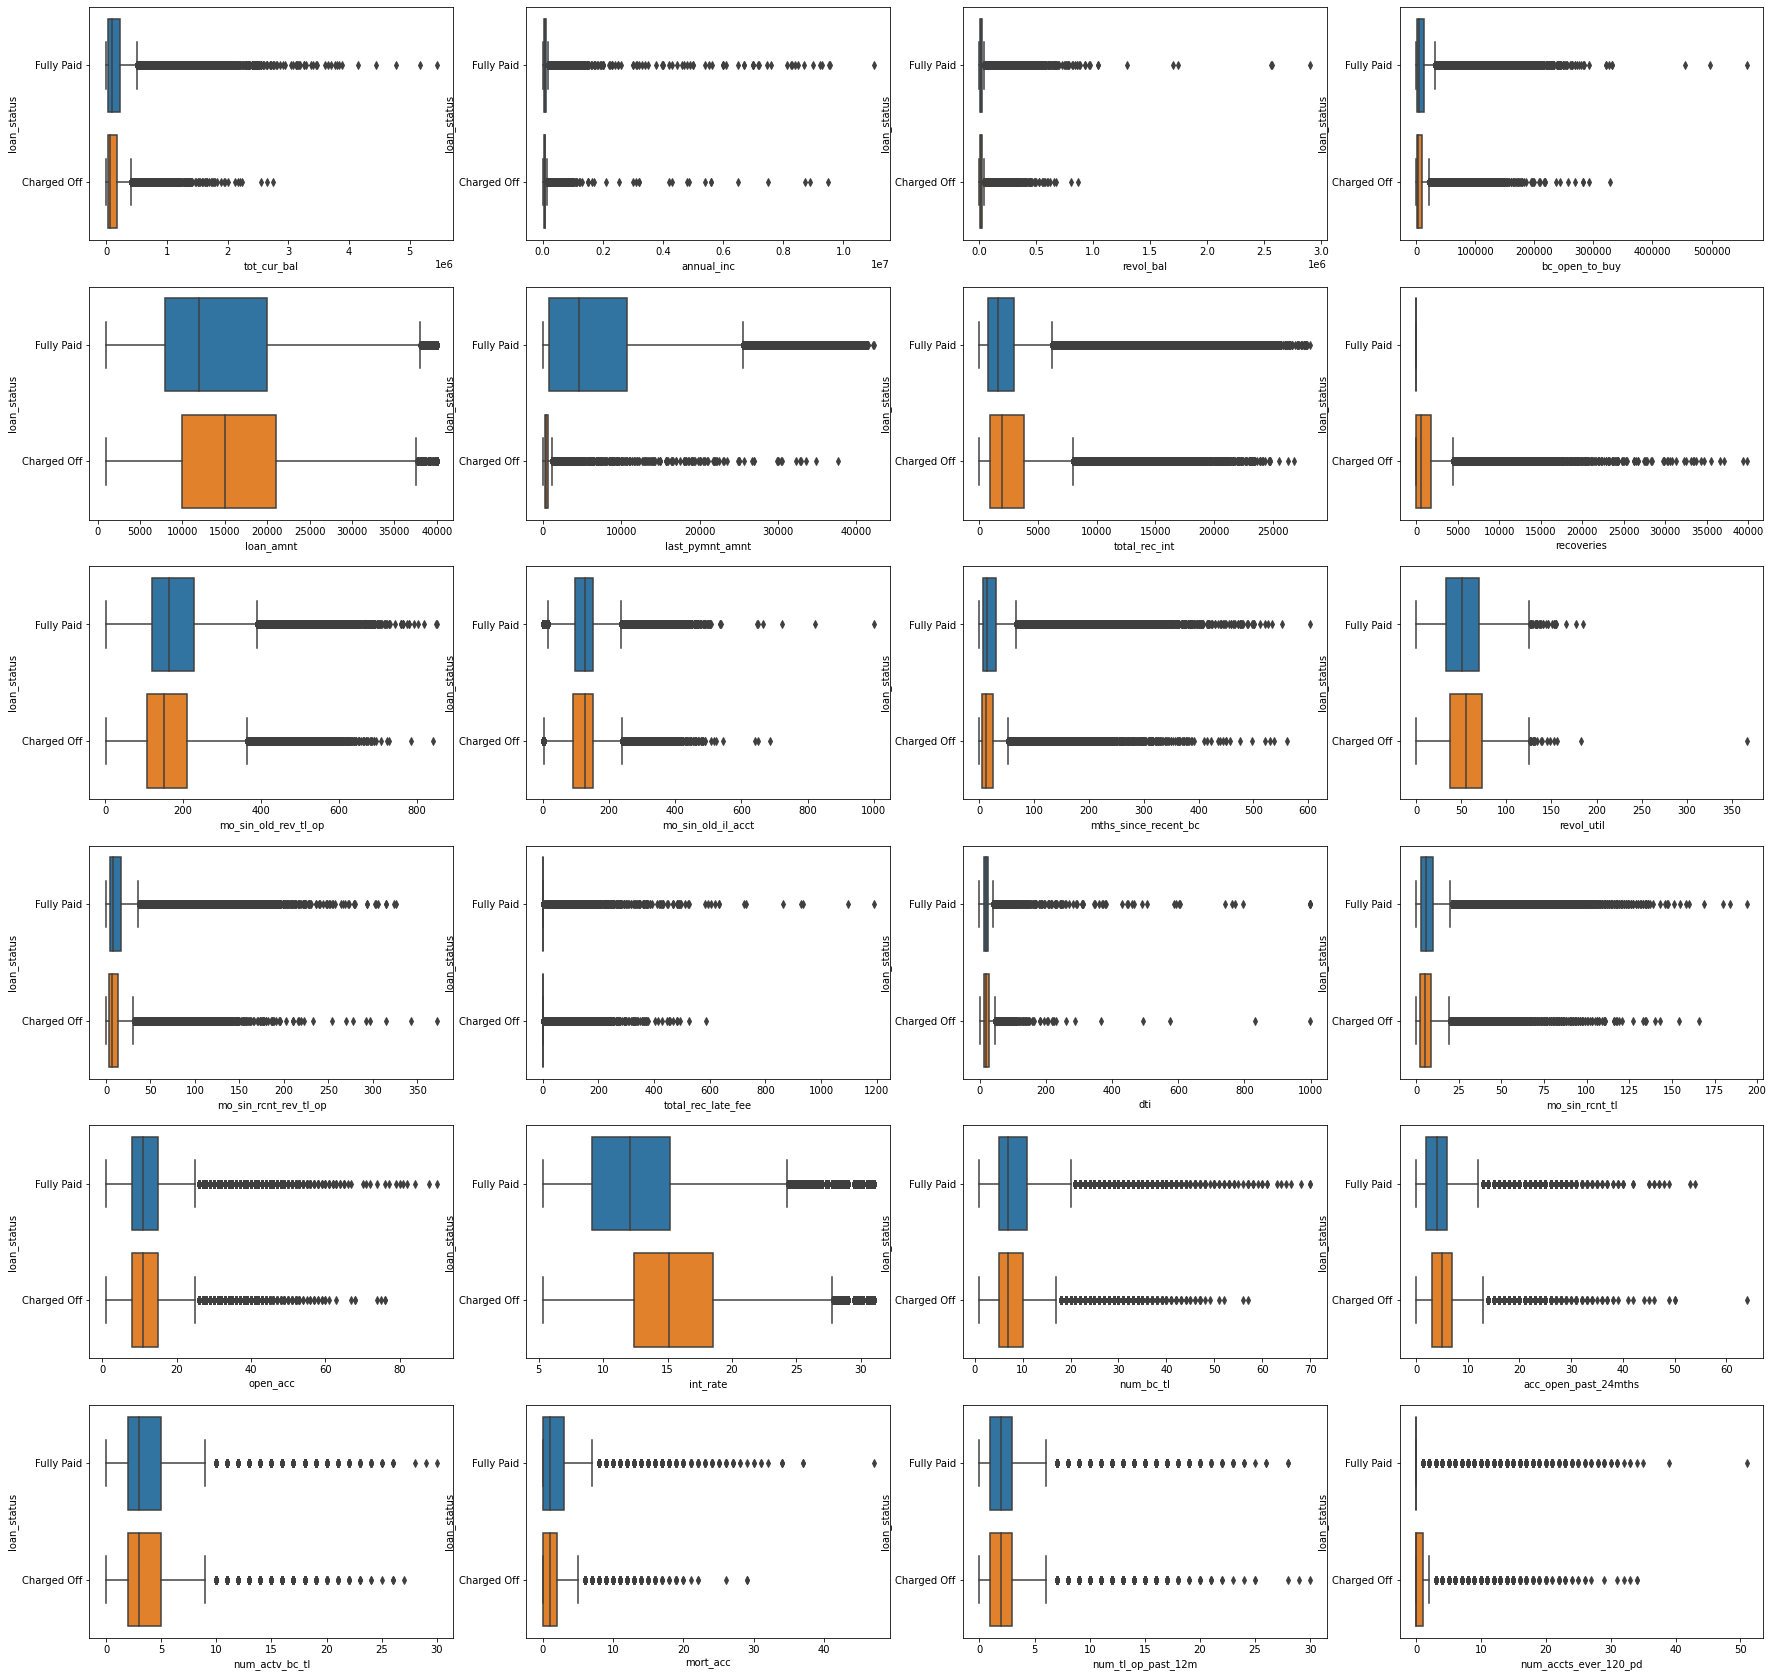

In [13]:
features = top30_n_high_var
fig, axes = plt.subplots(6, 4, figsize=(30, 30))
count=0
for i in range(0,6):
    for j in range(0,4):
        sns.boxplot(ax=axes[i][j], x=features[count], y=df3["loan_status"], data=df3)
        count = count + 1
        

In [14]:
#removing outliers from numerical column
for numerical_column in top30_n_high_var:
    Q1 = df3[numerical_column].quantile(0.25)
    Q3 = df3[numerical_column].quantile(0.75)
    lower_whisker = Q1
    upper_whisker = Q3
    df3[numerical_column]=np.where(df3[numerical_column]>upper_whisker,upper_whisker,np.where(df3[numerical_column]<lower_whisker,lower_whisker,df3[numerical_column]))

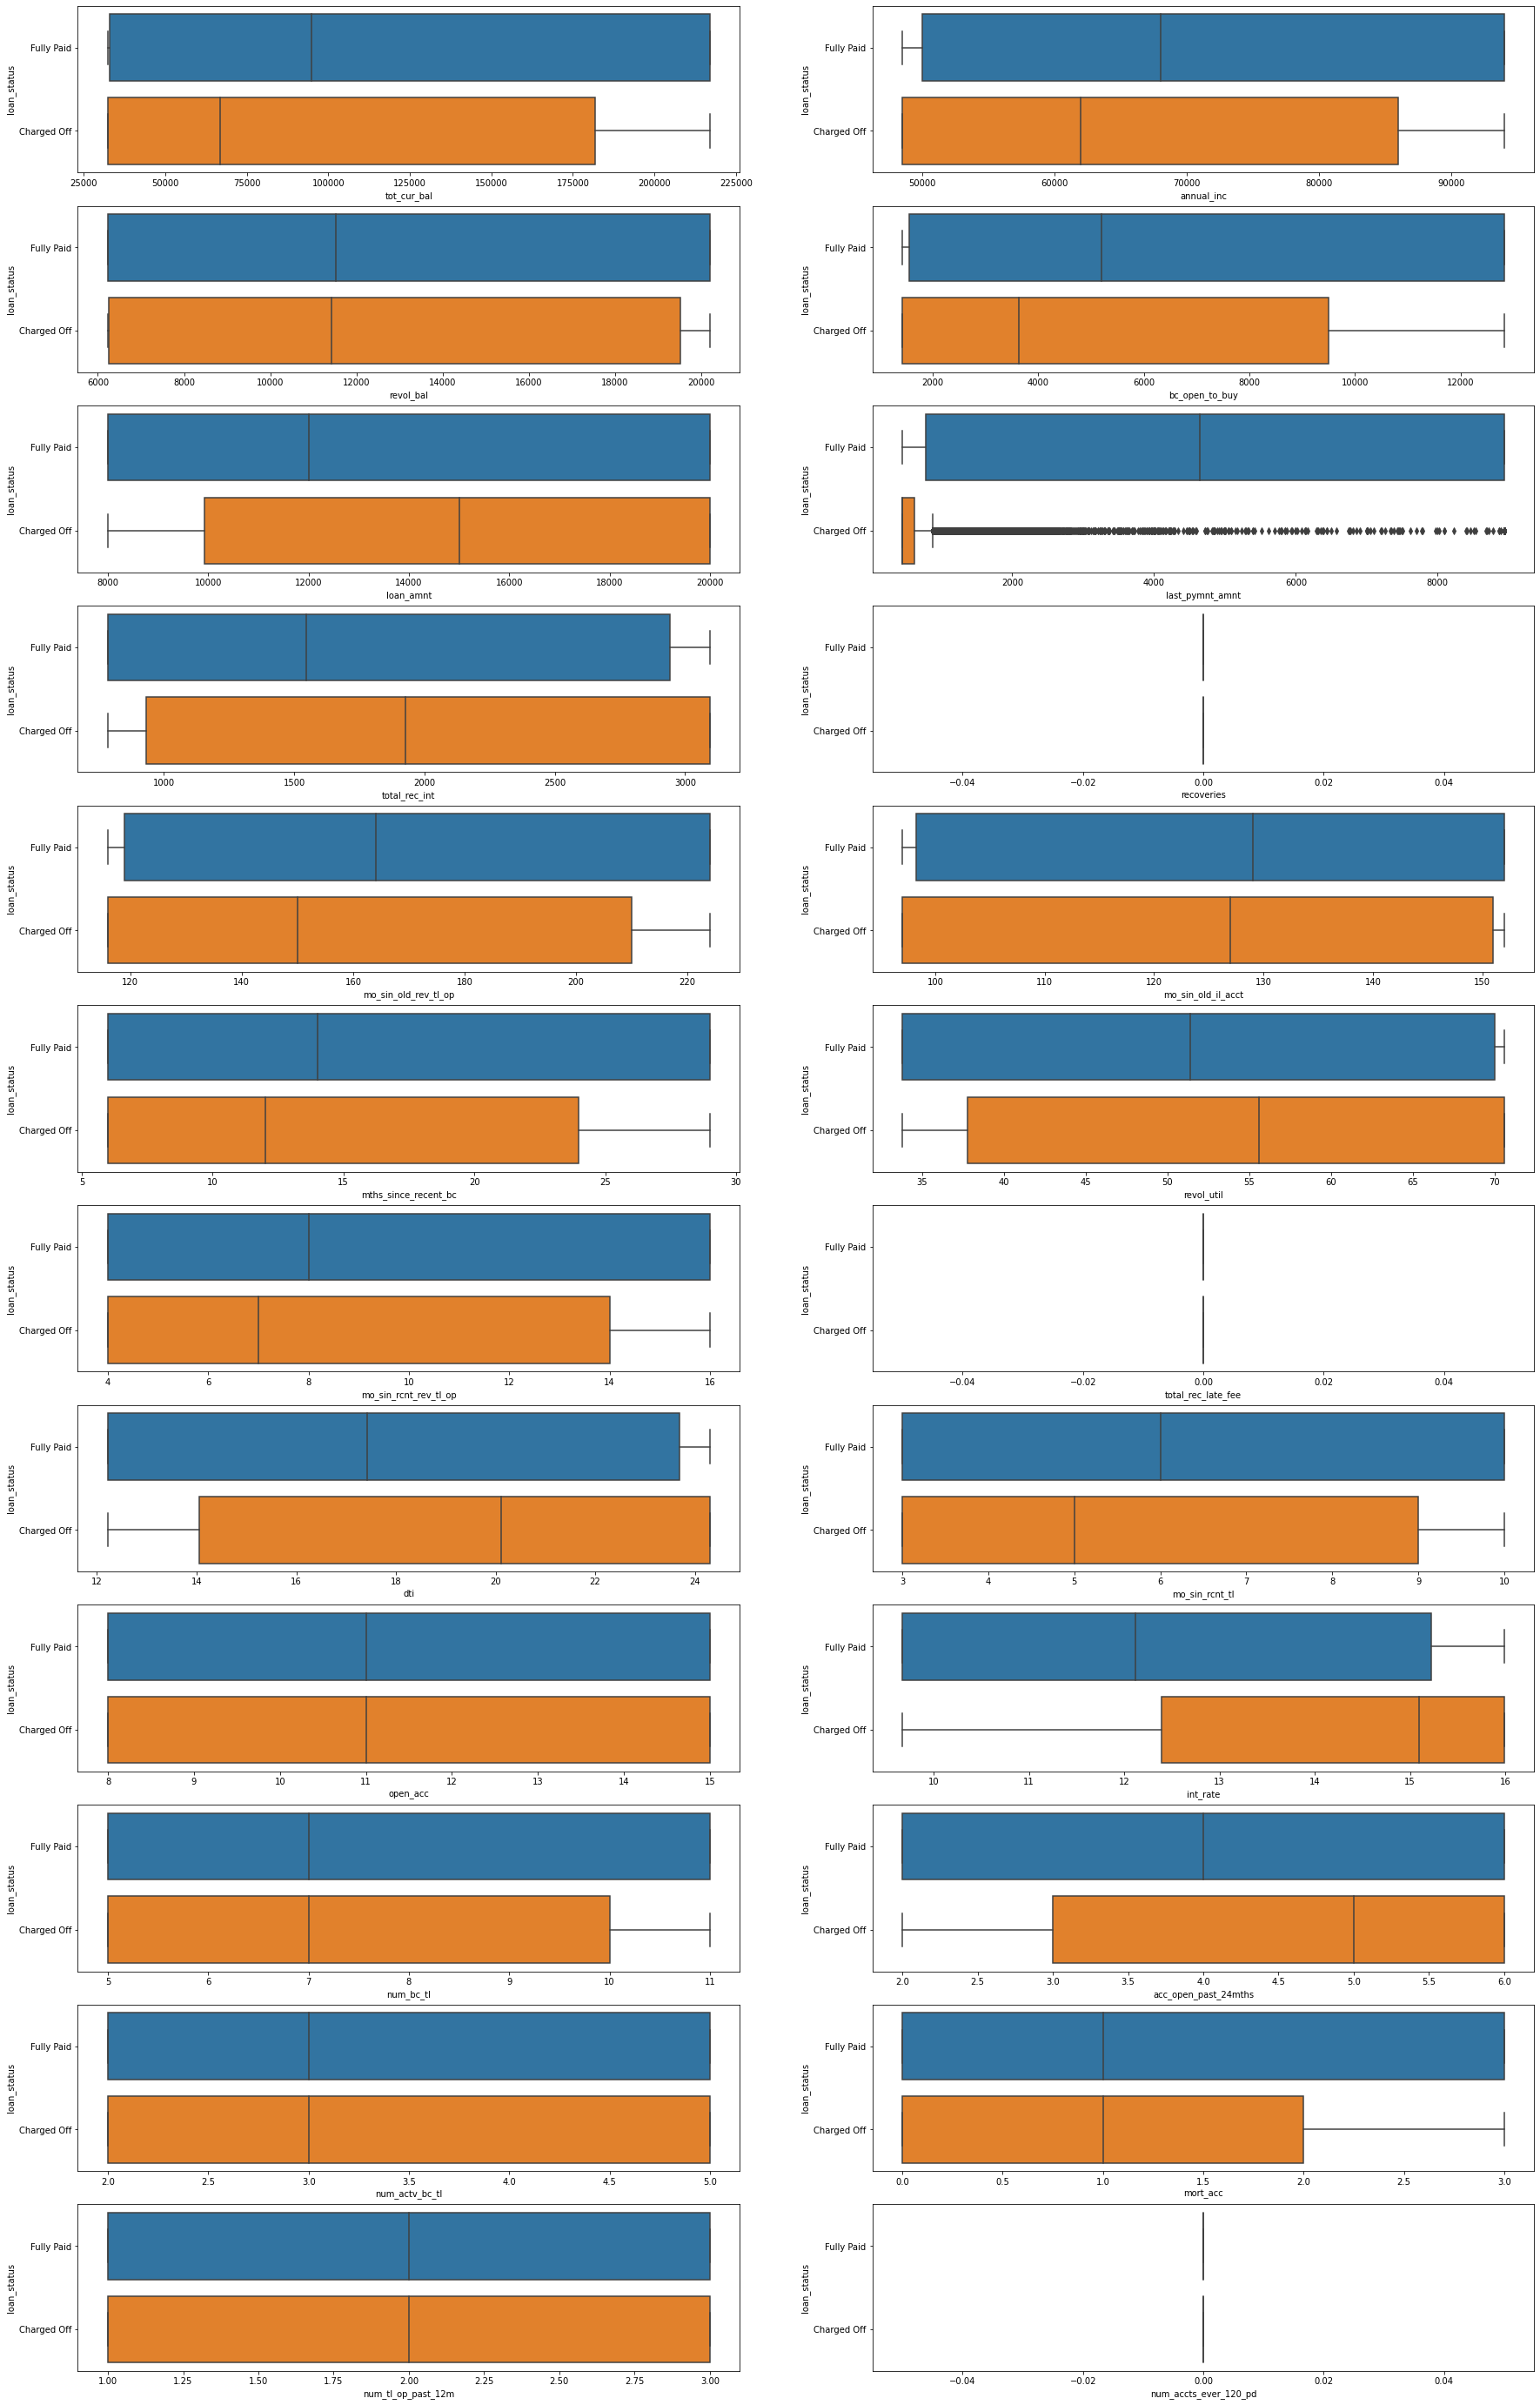

In [15]:
features = top30_n_high_var
fig, axes = plt.subplots(12, 2, figsize=(30, 50))
count=0
for i in range(0,12):
    for j in range(0,2):
        sns.boxplot(ax=axes[i][j], x=features[count], y=df3["loan_status"], data=df3)
        count = count + 1
        

In [16]:
df3["recoveries"].head()

100    0.0
152    0.0
170    0.0
186    0.0
215    0.0
Name: recoveries, dtype: float64

In [17]:
cat_features = [column for column in df2.columns if df2[column].dtype == object]
print(len(cat_features))

22


In [18]:
for cat in cat_features:
  print(cat, len(df2[cat].unique()))


term 2
grade 7
sub_grade 35
emp_title 311101
emp_length 11
home_ownership 6
verification_status 3
issue_d 77
loan_status 2
pymnt_plan 1
purpose 14
title 35165
zip_code 939
addr_state 51
earliest_cr_line 719
initial_list_status 2
last_pymnt_d 78
last_credit_pull_d 80
application_type 2
hardship_flag 2
disbursement_method 2
debt_settlement_flag 2


In [19]:
amount_missing = pd.DataFrame(df1.isnull().sum()/len(df1))
amount_missing.columns = ['missing_prop']
cols = amount_missing[amount_missing['missing_prop'] < 0.1].index
print(len(cols))
df2 = df1[cols].dropna(axis = 0)
df_temp = df2

86


In [20]:
df2.shape

(1056242, 86)

In [21]:
from sklearn.preprocessing import LabelEncoder
# creating instance of labelencoder
labelencoder = LabelEncoder()
for cat in cat_features:
    df_temp[cat] = labelencoder.fit_transform(df2[cat])

In [22]:
print(len(cat_features))
cat_features.remove("loan_status")
print(len(cat_features))

22
21


In [23]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [24]:
x= df_temp[cat_features]
y = df_temp["loan_status"]
f_score=chi2(x,y)    
f_score
p_value=pd.Series(f_score[1],index=x.columns)
p_value.sort_values(ascending=True,inplace=True)
print(p_value<0.05)

term                     True
last_credit_pull_d       True
earliest_cr_line         True
zip_code                 True
verification_status      True
debt_settlement_flag     True
emp_title                True
sub_grade                True
grade                    True
home_ownership           True
purpose                  True
emp_length               True
last_pymnt_d             True
application_type         True
title                    True
issue_d                  True
addr_state               True
hardship_flag            True
initial_list_status     False
disbursement_method     False
pymnt_plan              False
dtype: bool


In [25]:
from sklearn.feature_selection import SelectKBest
chi2_features = SelectKBest(chi2, k = 9)
X_kbest_features = chi2_features.fit_transform(x, y)

filter = chi2_features.get_support()
print("Top 8 Categorical featurs with best P Value are")
cat_features = np.array(cat_features)
selectedCatFeatures = cat_features[filter]
print(selectedCatFeatures)


Top 8 Categorical featurs with best P Value are
['term' 'grade' 'sub_grade' 'emp_title' 'home_ownership'
 'verification_status' 'zip_code' 'last_credit_pull_d'
 'debt_settlement_flag']


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

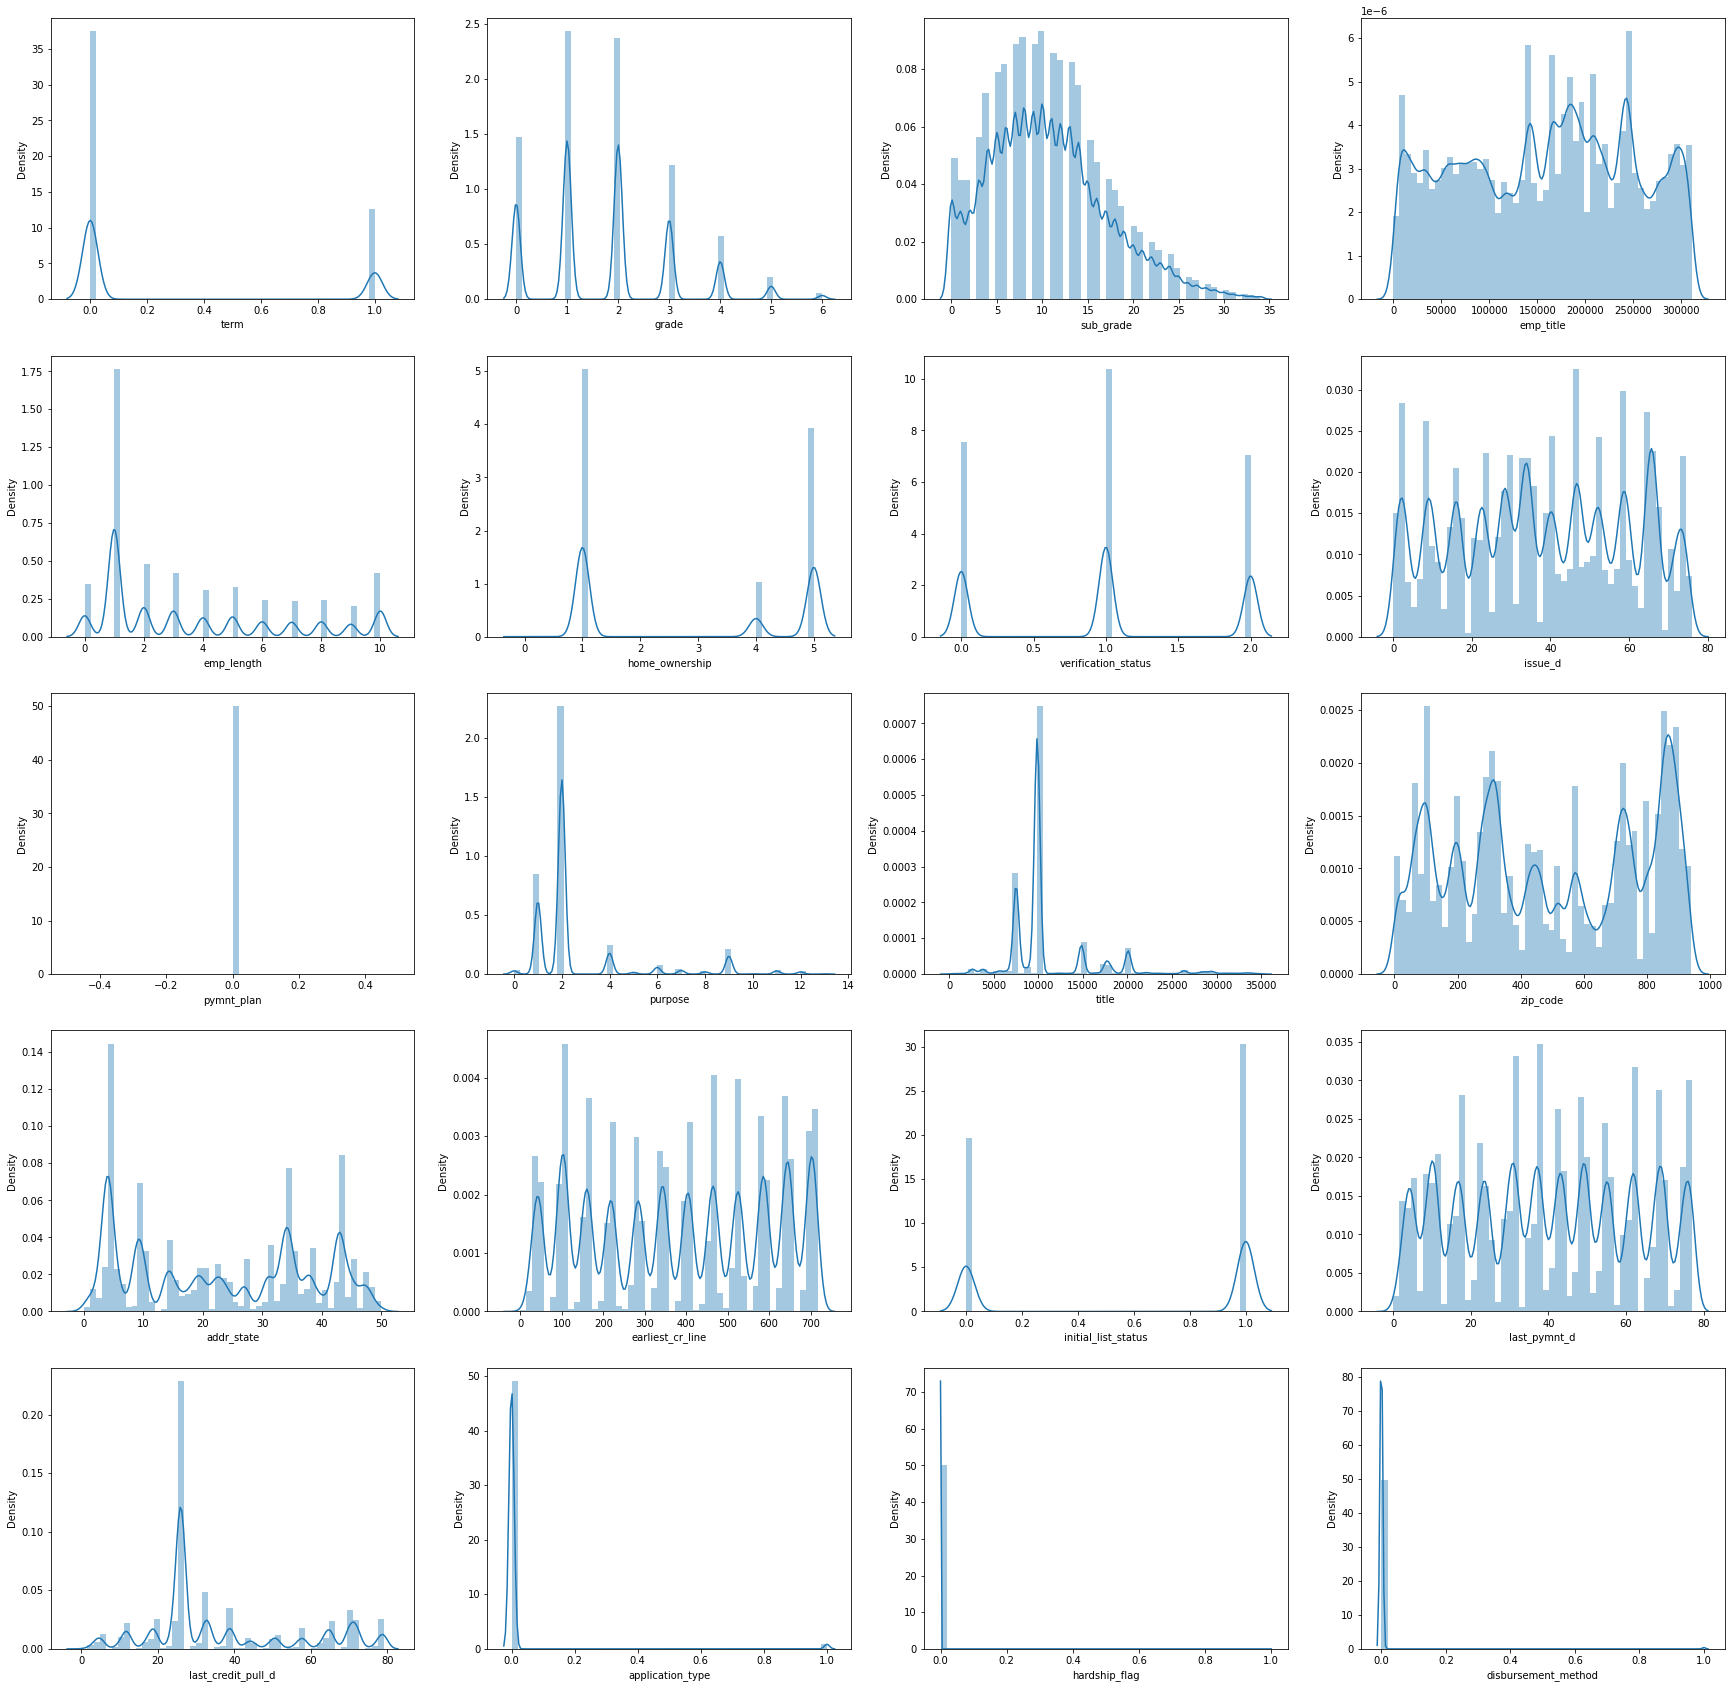

In [26]:
fig, axes = plt.subplots(5, 4, figsize=(30, 30))
count=0
for i in range(0,5):
    for j in range(0,4):
            sns.distplot(ax=axes[i][j], x=df_temp[cat_features[count]])
            axes[i][j].set_xlabel(cat_features[count])
            count = count + 1

Text(0.5, 0, 'debt_settlement_flag')

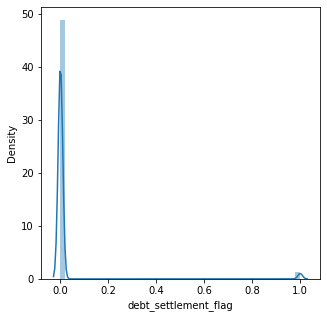

In [28]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
sns.distplot(ax = axes , x=df_temp[cat_features[20]])
axes.set_xlabel(cat_features[20])

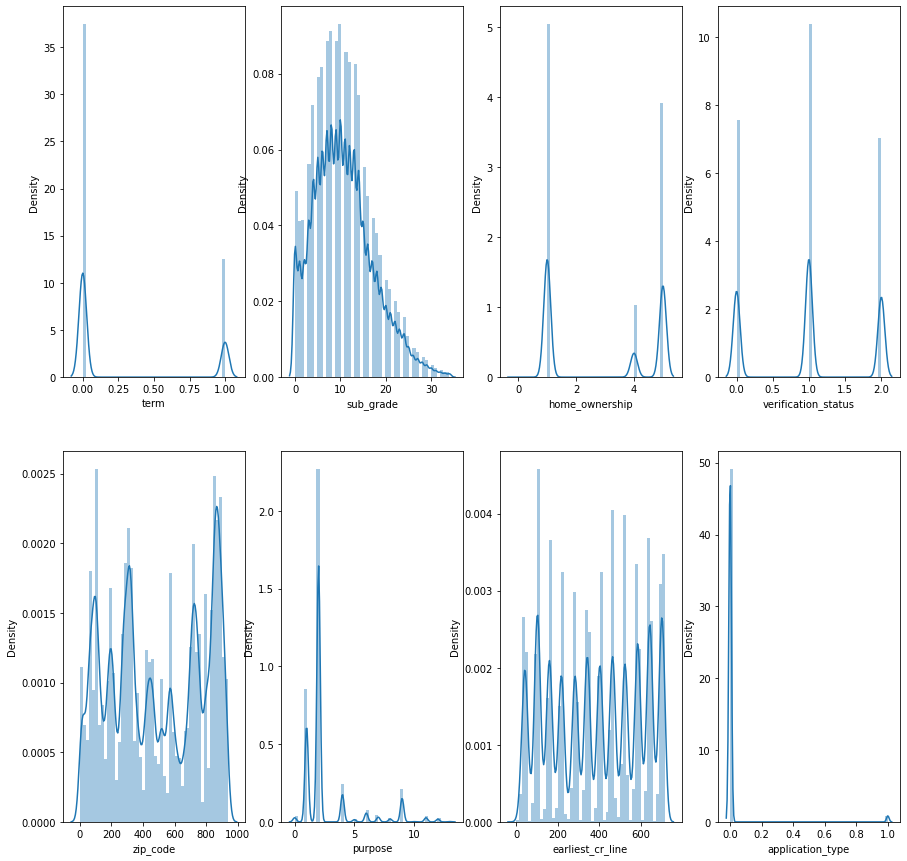

In [29]:
selectedCatFeatures = ["term","sub_grade","home_ownership","verification_status","zip_code","purpose","earliest_cr_line","application_type",]

fig, axes = plt.subplots(2, 4, figsize=(15, 15))
count=0
for i in range(0,2):
    for j in range(0,4):
            sns.distplot(ax=axes[i][j], x=df_temp[selectedCatFeatures[count]], label=df_temp["loan_status"])
            axes[i][j].set_xlabel(selectedCatFeatures[count])
            count = count + 1

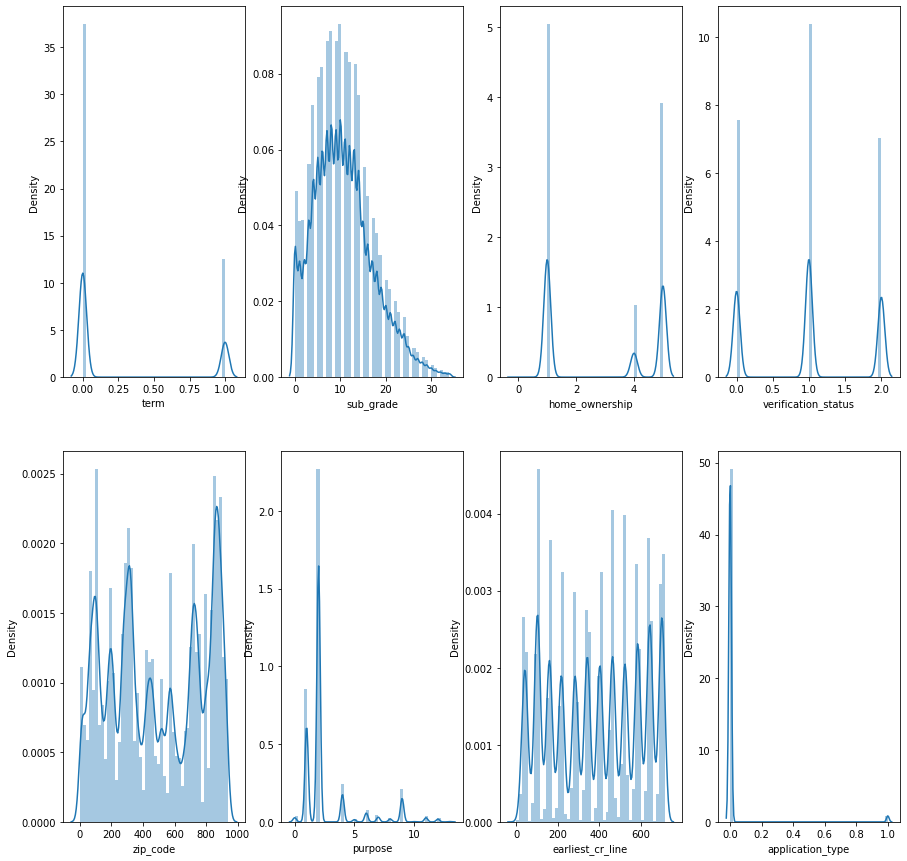

In [30]:
selectedCatFeatures = ["term","sub_grade","home_ownership","verification_status","zip_code","purpose","earliest_cr_line","application_type",]
fig, axes = plt.subplots(2, 4, figsize=(15, 15))
count=0
for i in range(0,2):
    for j in range(0,4):
            sns.distplot(ax=axes[i][j], x=df_temp[selectedCatFeatures[count]], label=df_temp["loan_status"])
            axes[i][j].set_xlabel(selectedCatFeatures[count])
            count = count + 1

In [31]:
featuredSelected = ["last_pymnt_amnt","annual_inc","num_accts_ever_120_pd","total_rec_int",
                    "mo_sin_old_rev_tl_op","num_tl_op_past_12m","mo_sin_rcnt_rev_tl_op","dti","total_acc",
                    "total_rec_late_fee","mo_sin_rcnt_tl","pct_tl_nvr_dlq","int_rate","num_bc_tl","acc_open_past_24mths",
                    "mort_acc","mths_since_recent_bc","term","sub_grade","home_ownership","verification_status","zip_code",
                    "purpose","earliest_cr_line","application_type","loan_status"]

df_selected = df1[featuredSelected]
df_selected.head()

,last_pymnt_amnt,annual_inc,num_accts_ever_120_pd,total_rec_int,mo_sin_old_rev_tl_op,num_tl_op_past_12m,mo_sin_rcnt_rev_tl_op,dti,total_acc,total_rec_late_fee,mo_sin_rcnt_tl,pct_tl_nvr_dlq,int_rate,num_bc_tl,acc_open_past_24mths,mort_acc,mths_since_recent_bc,term,sub_grade,home_ownership,verification_status,zip_code,purpose,earliest_cr_line,application_type,loan_status
100,30082.32,100000.0,0.0,26.44,73.0,2.0,23.0,30.46,19.0,0.0,2.0,89.5,22.35,5.0,4.0,1.0,23.0,36 months,D5,MORTGAGE,Source Verified,917xx,debt_consolidation,Jan-2012,Joint App,Fully Paid
152,40910.48,45000.0,0.0,856.68,70.0,4.0,2.0,50.53,37.0,0.0,2.0,100.0,16.14,7.0,5.0,1.0,2.0,60 months,C4,MORTGAGE,Verified,456xx,credit_card,Jun-2009,Joint App,Fully Paid
170,20228.39,100000.0,0.0,215.79,238.0,1.0,1.0,18.92,19.0,0.0,1.0,94.7,7.56,6.0,5.0,5.0,1.0,36 months,A3,MORTGAGE,Not Verified,982xx,credit_card,Feb-1999,Joint App,Fully Paid
186,4553.46,38500.0,1.0,49.22,69.0,4.0,2.0,4.64,25.0,0.0,2.0,91.7,11.31,6.0,8.0,0.0,2.0,36 months,B3,RENT,Not Verified,786xx,credit_card,Dec-2003,Individual,Fully Paid
215,8754.30,450000.0,0.0,310.15,89.0,2.0,12.0,12.37,37.0,0.0,12.0,100.0,27.27,10.0,10.0,4.0,18.0,36 months,E5,MORTGAGE,Verified,020xx,credit_card,Oct-1997,Joint App,Fully Paid


In [32]:
amount_missing = pd.DataFrame(df_selected.isnull().sum()/len(df_selected))
amount_missing.columns = ['missing_prop']
cols = amount_missing[amount_missing['missing_prop'] < 0.1].index
df_selected = df_selected[cols].dropna(axis = 0)

Text(0.5, 1.0, 'Distribution of Loan Status for each purpose')

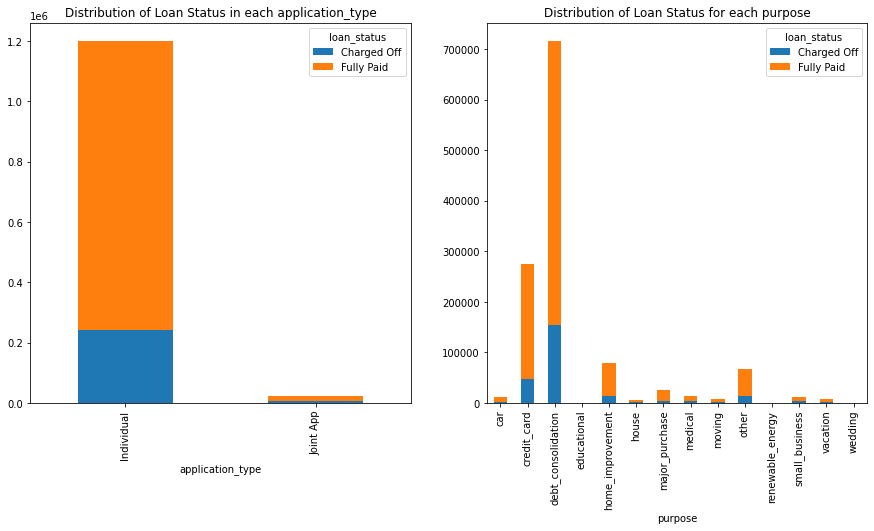

In [33]:
fig, ax = plt.subplots(1, 2, figsize = (15, 7))
select = ["loan_status","application_type"]
tmp = df_selected[select]
tmp['count'] = 1
tmp = tmp.pivot_table(values = 'count', index = 'application_type', columns='loan_status', aggfunc = 'sum')

tmp.plot(kind = 'bar', stacked = True, ax = ax[0])
ax[0].set_xlabel('application_type')
ax[0].set_title('Distribution of Loan Status in each application_type')


select = ["loan_status","purpose"]
tmp = df_selected[select]
tmp['count'] = 1
tmp = tmp.pivot_table(values = 'count', index = 'purpose', columns='loan_status', aggfunc = 'sum')

tmp.plot(kind = 'bar', stacked = True, ax = ax[1])
ax[1].set_xlabel('purpose')
ax[1].set_title('Distribution of Loan Status for each purpose')



Text(0.5, 1.0, 'Distribution of Loan Status for each home_ownership')

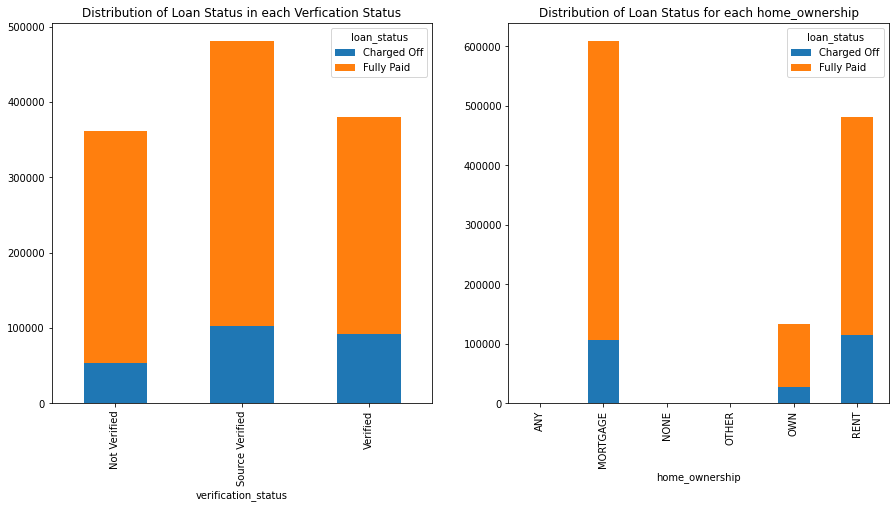

In [34]:
fig, ax = plt.subplots(1, 2, figsize = (15, 7))
select = ["loan_status","verification_status"]
tmp = df_selected[select]
tmp['count'] = 1
tmp = tmp.pivot_table(values = 'count', index = 'verification_status', columns='loan_status', aggfunc = 'sum')

tmp.plot(kind = 'bar', stacked = True, ax = ax[0])
ax[0].set_xlabel('verification_status')
ax[0].set_title('Distribution of Loan Status in each Verfication Status')


select = ["loan_status","home_ownership"]
tmp = df_selected[select]
tmp['count'] = 1
tmp = tmp.pivot_table(values = 'count', index = 'home_ownership', columns='loan_status', aggfunc = 'sum')

tmp.plot(kind = 'bar', stacked = True, ax = ax[1])
ax[1].set_xlabel('home_ownership')
ax[1].set_title('Distribution of Loan Status for each home_ownership')



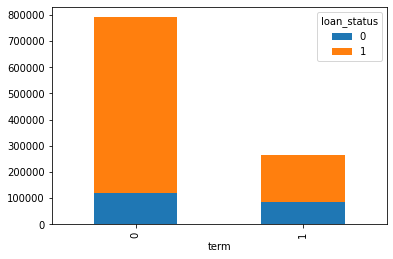

In [35]:
cat_features = ["term"]
for cat in cat_features:
    tmp = df2[['loan_status', cat]]
    tmp['count'] = 1
    tmp = tmp.pivot_table(values = 'count', index = cat, columns='loan_status', aggfunc = 'sum')
    tmp.plot(kind = 'bar', stacked = True)


<AxesSubplot:xlabel='purpose', ylabel='int_rate'>

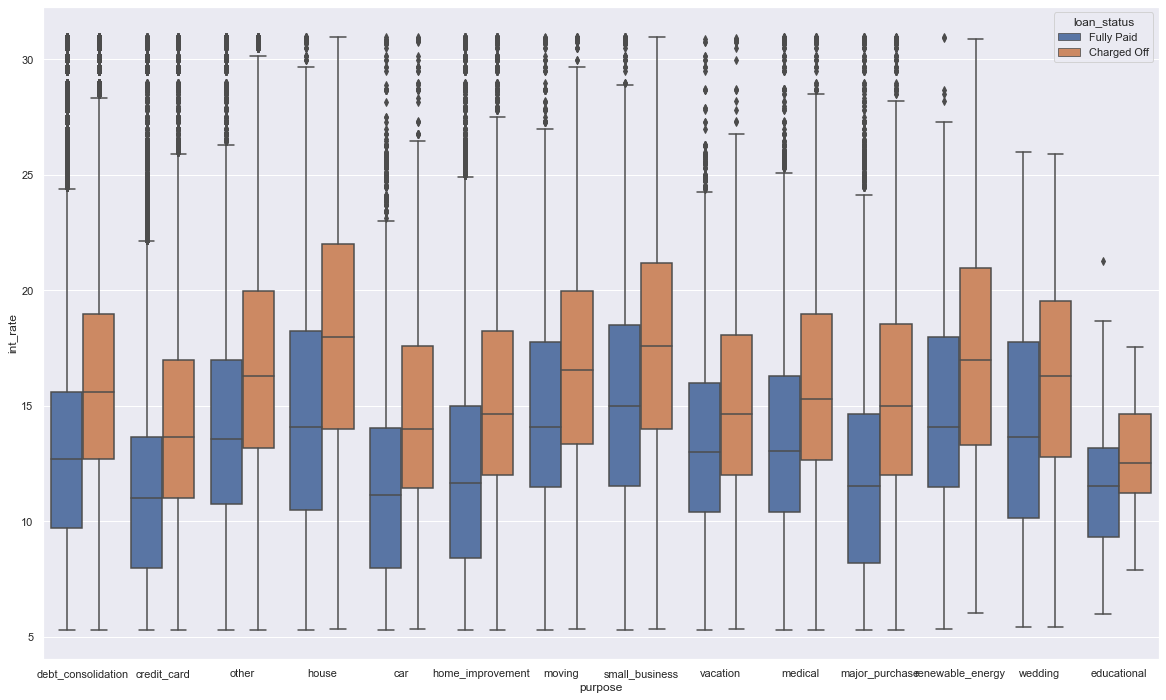

In [ ]:
sns.set(rc = {'figure.figsize':(20,12)})
sns.boxplot(y=df_selected["int_rate"], x=df_selected["purpose"], orient = "v", hue=df_selected["loan_status"], data=df_selected)

In [36]:
df_selected.describe().T

,count,mean,std,min,25%,50%,75%,max
last_pymnt_amnt,1223397.0,5613.462396,7225.460992,0.000000e+00,416.61,2307.35,8607.69,42192.05
annual_inc,1223397.0,76683.910123,70794.997197,1.600000e+01,46000.00,65000.00,91000.00,10999200.00
num_accts_ever_120_pd,1223397.0,0.507150,1.321256,0.000000e+00,0.00,0.00,0.00,51.00
total_rec_int,1223397.0,2385.588255,2567.666790,0.000000e+00,769.07,1573.41,3021.99,28192.50
mo_sin_old_rev_tl_op,1223397.0,181.601228,94.342190,2.000000e+00,117.00,164.00,230.00,852.00
num_tl_op_past_12m,1223397.0,2.186412,1.846673,0.000000e+00,1.00,2.00,3.00,32.00
mo_sin_rcnt_rev_tl_op,1223397.0,12.973217,16.083493,0.000000e+00,4.00,8.00,16.00,438.00
dti,1223397.0,18.479018,11.080389,-1.000000e+00,11.98,17.81,24.33,999.00
total_acc,1223397.0,25.199243,12.026461,2.000000e+00,16.00,23.00,32.00,176.00
total_rec_late_fee,1223397.0,1.559822,10.685471,-5.100000e-09,0.00,0.00,0.00,1188.83


In [37]:
df_selected.columns

Index(['last_pymnt_amnt', 'annual_inc', 'num_accts_ever_120_pd',
       'total_rec_int', 'mo_sin_old_rev_tl_op', 'num_tl_op_past_12m',
       'mo_sin_rcnt_rev_tl_op', 'dti', 'total_acc', 'total_rec_late_fee',
       'mo_sin_rcnt_tl', 'pct_tl_nvr_dlq', 'int_rate', 'num_bc_tl',
       'acc_open_past_24mths', 'mort_acc', 'mths_since_recent_bc', 'term',
       'sub_grade', 'home_ownership', 'verification_status', 'zip_code',
       'purpose', 'earliest_cr_line', 'application_type', 'loan_status'],
      dtype='object')

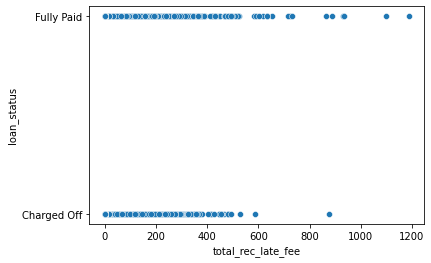

In [38]:
g=sns.scatterplot(data=df_selected, x="total_rec_late_fee", y="loan_status")


In [39]:
df_selected["mort_acc"].unique()

array([ 1.,  5.,  0.,  4.,  2.,  3., 11.,  7.,  6.,  9.,  8., 10., 18.,
       12., 15., 14., 20., 13., 16., 24., 29., 17., 26., 19., 37., 21.,
       28., 22., 23., 25., 35., 32., 30., 27., 47., 34., 31.])

In [40]:
df_selected["earliest_cr_line"] = df_selected["earliest_cr_line"].str.split(pat="-", expand=True)[1]
df_selected["earliest_cr_line"].unique()

array(['2012', '2009', '1999', '2003', '1997', '1995', '2004', '2007',
       '2002', '2006', '1987', '2008', '2005', '2001', '1982', '2014',
       '2010', '1983', '1993', '2015', '1989', '2013', '1992', '2011',
       '1994', '2000', '1996', '1988', '1975', '1984', '1985', '1991',
       '1990', '1998', '1965', '1986', '1980', '1972', '1973', '1981',
       '1978', '1976', '1967', '1969', '1961', '1977', '1979', '1966',
       '1970', '1968', '1971', '1974', '1964', '1950', '1963', '1956',
       '1951', '1962', '1960', '1959', '1954', '1952', '1955', '1957',
       '1953', '1958', '1945', '1948', '1944', '1934', '1946', '1949'],
      dtype=object)

Text(0.5, 1.0, 'Distribution of Loan Status with acc_open_past_24mths')

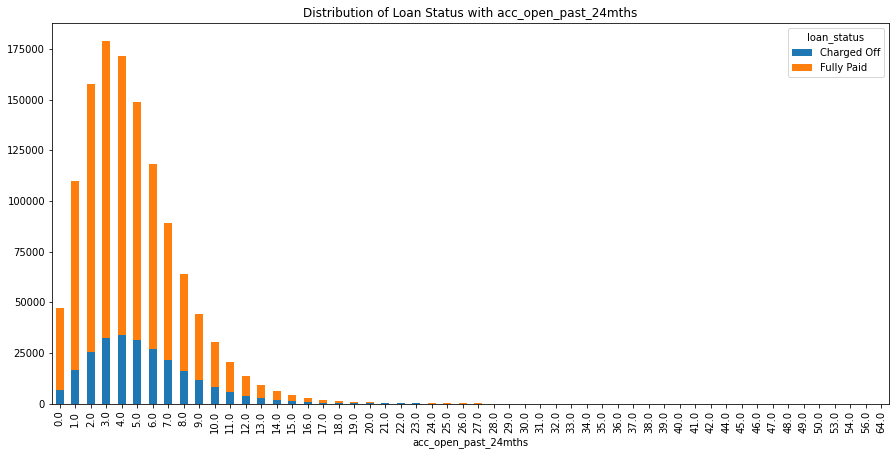

In [41]:
fig, ax = plt.subplots(1, 1, figsize = (15, 7))
select = ["acc_open_past_24mths","loan_status"]
tmp = df_selected[select]
tmp['count'] = 1
tmp = tmp.pivot_table(values = 'count', index = 'acc_open_past_24mths', columns='loan_status', aggfunc = 'sum')

tmp.plot(kind = 'bar', stacked = True, ax = ax)
ax.set_xlabel('acc_open_past_24mths')
ax.set_title('Distribution of Loan Status with acc_open_past_24mths')

Text(0.5, 1.0, 'Distribution of Loan Status with Earliest Credit Line')

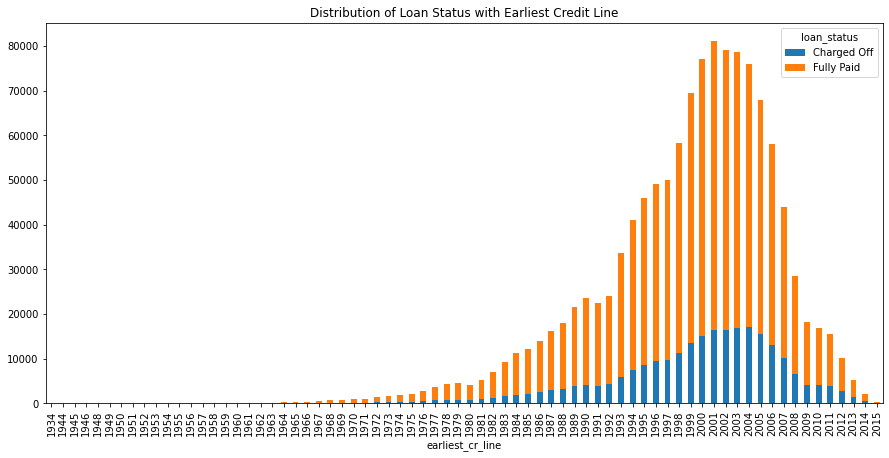

In [42]:
fig, ax = plt.subplots(1, 1, figsize = (15, 7))
select = ["earliest_cr_line","loan_status"]
tmp = df_selected[select]
tmp['count'] = 1
tmp = tmp.pivot_table(values = 'count', index = 'earliest_cr_line', columns='loan_status', aggfunc = 'sum')

tmp.plot(kind = 'bar', stacked = True, ax = ax)
ax.set_xlabel('earliest_cr_line')
ax.set_title('Distribution of Loan Status with Earliest Credit Line')

Text(0.5, 1.0, 'Distribution of Loan Status with Sub_Grade')

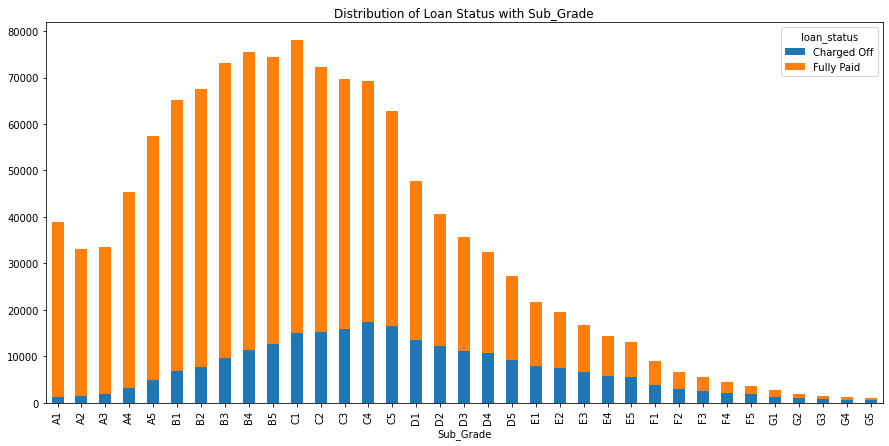

In [43]:
fig, ax = plt.subplots(1, 1, figsize = (15, 7))
select = ["sub_grade","loan_status"]
tmp = df_selected[select]
tmp['count'] = 1
tmp = tmp.pivot_table(values = 'count', index = 'sub_grade', columns='loan_status', aggfunc = 'sum')

tmp.plot(kind = 'bar', stacked = True, ax = ax)
ax.set_xlabel('Sub_Grade')
ax.set_title('Distribution of Loan Status with Sub_Grade')